# COMP 576 Fall Final Project
# Zixuan Wang, Jiayi Du, Shicong Wang

# Pneumonia Diagnosis With Machine Learning

In [6]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Import data

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


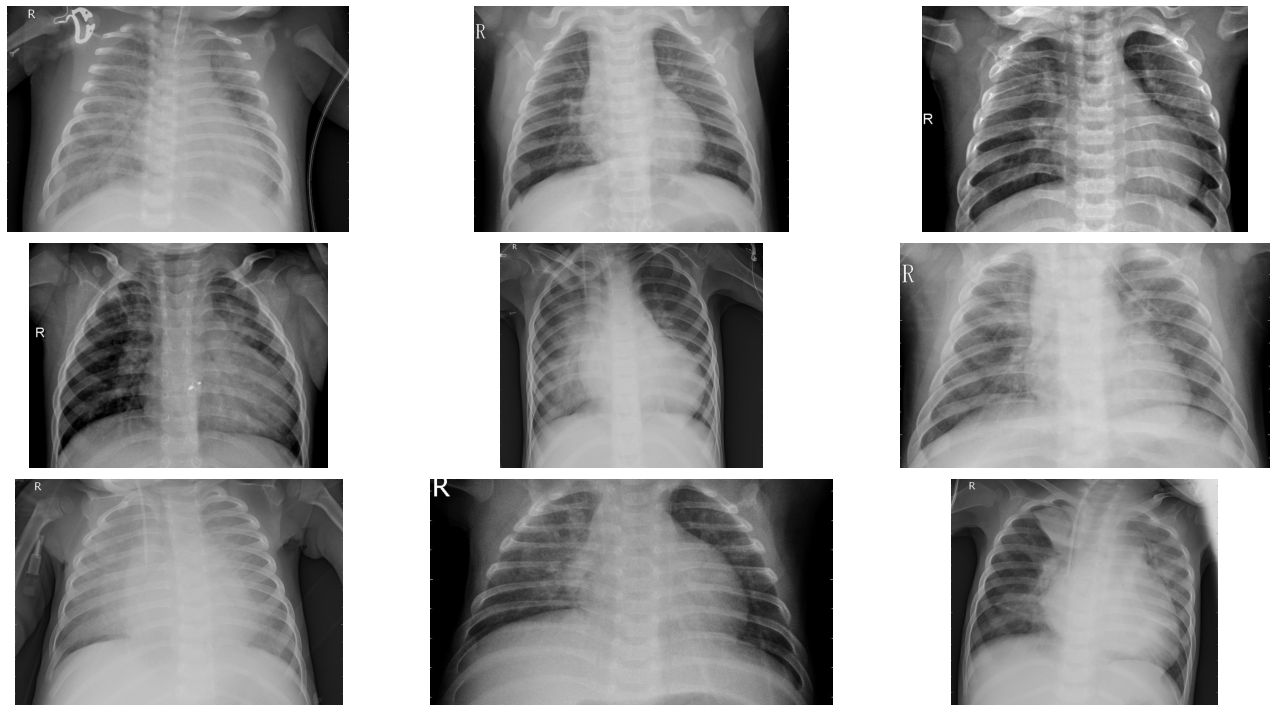

In [7]:
train_dir = "./data/train"
test_dir = "./data/test"
val_dir = "./data/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("./data/train/PNEUMONIA")
pneumonia_dir = "./data/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

(1858, 2090)


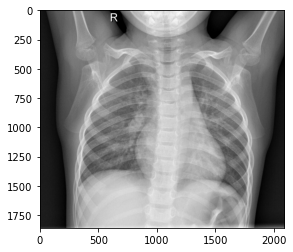

In [8]:
normal = os.listdir("./data/train/NORMAL")
normal_dir = "./data/train/NORMAL"

sample_image =plt.imread(os.path.join(normal_dir, normal[0]))
plt.imshow(sample_image,cmap='gray')
print(sample_image.shape)

# Preprcessing data

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Text(0.5, 1.0, 'Raw Chest X Ray Image')

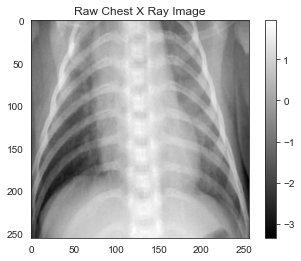

In [9]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            color_mode='grayscale',
                                            class_mode='binary',
                                            target_size=(256, 256))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                color_mode='grayscale',
                                                class_mode='binary',
                                                target_size=(256, 256))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            color_mode='grayscale',
                                            class_mode='binary',
                                            target_size=(256, 256))
                                        
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

# CNN

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                        

In [11]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [12]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=len(train),
    validation_steps=len(validation),
)

Epoch 1/10
652/652 [==============================] - 73s 98ms/step - loss: 0.5087 - accuracy: 0.8353 - val_loss: 0.7903 - val_accuracy: 0.6250
Epoch 2/10
652/652 [==============================] - 63s 97ms/step - loss: 0.1461 - accuracy: 0.9059 - val_loss: 0.5112 - val_accuracy: 0.7500
Epoch 3/10
652/652 [==============================] - 61s 93ms/step - loss: 0.1168 - accuracy: 0.9124 - val_loss: 1.1611 - val_accuracy: 0.6875
Epoch 4/10
652/652 [==============================] - 63s 97ms/step - loss: 0.0922 - accuracy: 0.9254 - val_loss: 0.4901 - val_accuracy: 0.7500
Epoch 5/10
652/652 [==============================] - 62s 95ms/step - loss: 0.1032 - accuracy: 0.9145 - val_loss: 0.8417 - val_accuracy: 0.6250
Epoch 6/10
652/652 [==============================] - 61s 94ms/step - loss: 0.0792 - accuracy: 0.9312 - val_loss: 1.2193 - val_accuracy: 0.5625
Epoch 7/10
652/652 [==============================] - 47s 72ms/step - loss: 0.1096 - accuracy: 0.9133 - val_loss: 0.6328 - val_accuracy:

In [13]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 6s 10ms/step - loss: 0.6521 - accuracy: 0.8494
Test Accuracy: 84.94%
652/652 [==============================] - 51s 79ms/step - loss: 0.3141 - accuracy: 0.9222
Train Accuracy: 92.22%


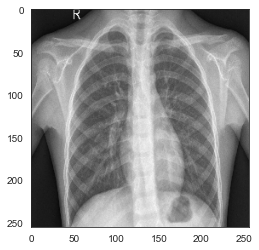

(1, 256, 256, 3)
Predicted class is: [0]


In [14]:
from keras.preprocessing import image

img_path = 'data/test/NORMAL/IM-0001-0001.jpeg'

img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
# classes = model.predict_classes(images, batch_size=10)
predict_x=model.predict(images[:,:,:,0], batch_size=10) 
classes_x=np.argmax(predict_x,axis=1)
print("Predicted class is:",classes_x)

12
(1, 61, 61, 64)
(1, 64)
(8, 8)


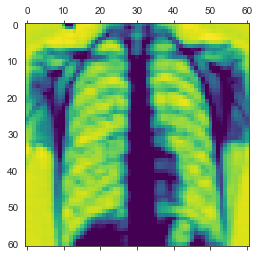

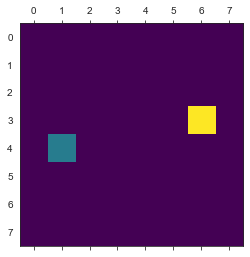

In [15]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

activations = activation_model.predict(img_tensor[:,:,:,0]) # Returns a list of five Numpy arrays: one array per layer activation
print(len(activations))
first_layer_activation = activations[9]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

last_layer_activation = activations[11]
print(last_layer_activation.shape)
last_layer_activation = tf.reshape(last_layer_activation,(8,8))
print(last_layer_activation.shape)
plt.matshow(last_layer_activation, cmap='viridis')


MemoryError: Unable to allocate 96.0 PiB for an array with shape (3544535296, 3810304) and data type float64

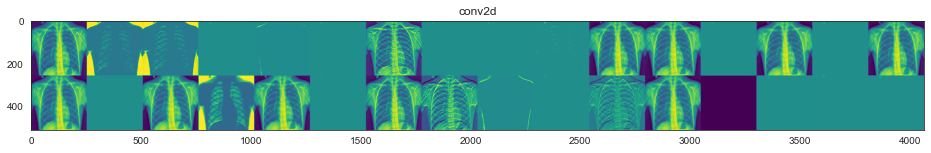

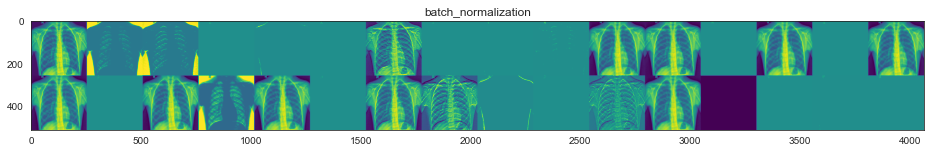

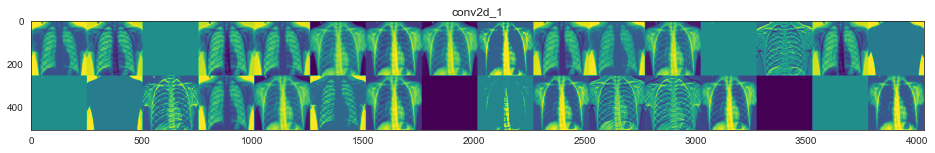

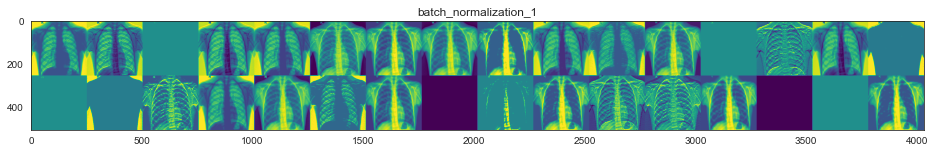

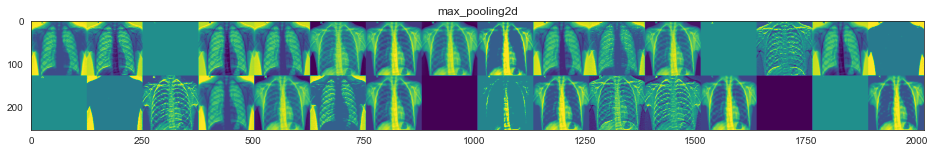

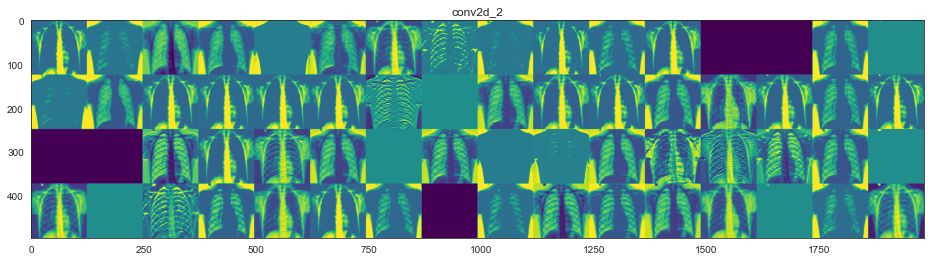

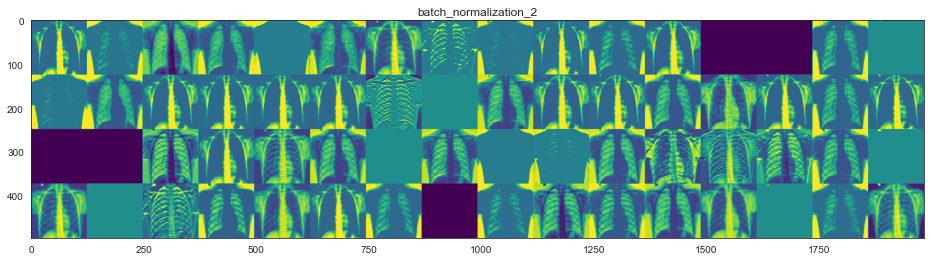

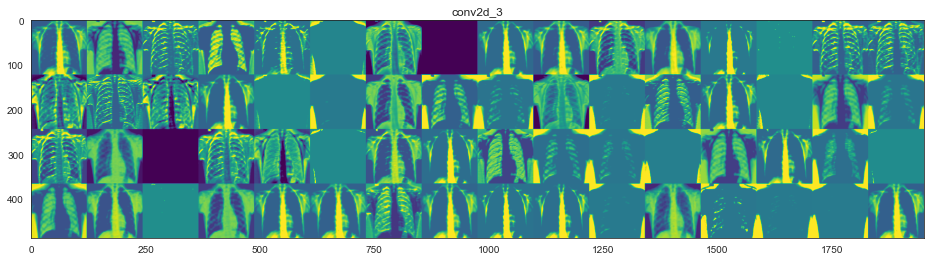

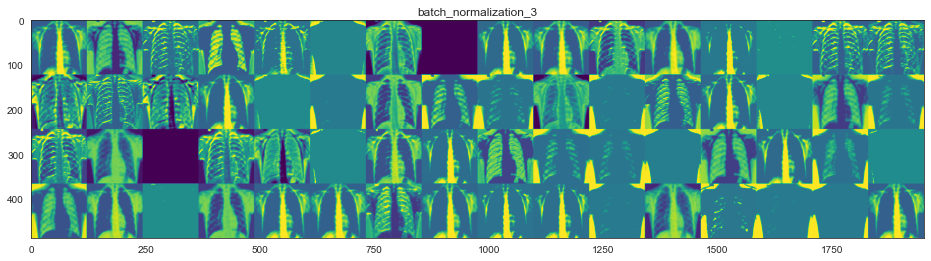

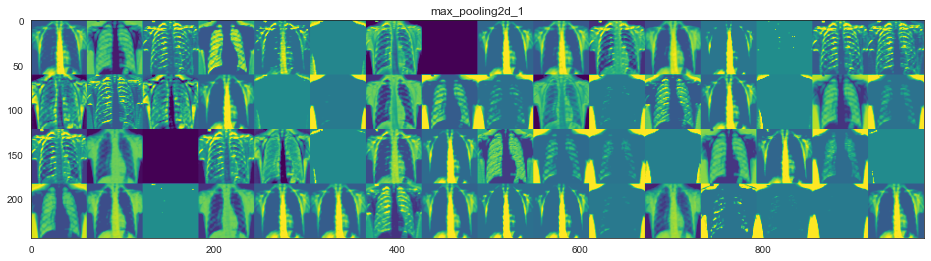

In [18]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Readjust the input picture size

In [19]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(256, 256))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(256, 256))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(256, 256))
                                        
sns.set_style('white')
generated_image, label = train.__getitem__(0)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# EfficientNet

In [20]:
from tensorflow.python.keras.applications.efficientnet import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization, Dropout

efficientnet_model = EfficientNetB0(input_shape=(256,256,3), include_top=False, weights='imagenet')

In [21]:
    efficientnet_model = tf.keras.Sequential([
        efficientnet_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    efficientnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [22]:
    r = efficientnet_model.fit(train,
      epochs=10,
      validation_data=validation,
      class_weight=class_weight,
    steps_per_epoch=len(train),
    validation_steps=len(validation),)

Epoch 1/10
652/652 [==============================] - 103s 144ms/step - loss: 0.1413 - accuracy: 0.8395 - precision: 0.9553 - recall: 0.8225 - val_loss: 1.5683 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
652/652 [==============================] - 87s 133ms/step - loss: 0.1023 - accuracy: 0.8982 - precision: 0.9713 - recall: 0.8893 - val_loss: 10.2067 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
652/652 [==============================] - 84s 129ms/step - loss: 0.0919 - accuracy: 0.9080 - precision: 0.9759 - recall: 0.8983 - val_loss: 3.0658 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
652/652 [==============================] - 85s 130ms/step - loss: 0.0862 - accuracy: 0.9151 - precision: 0.9772 - recall: 0.9068 - val_loss: 2.4571 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
652/652 [==============================] - 87s 133ms/step - loss: 0.0861 - accu

Text(0.5, 1.0, 'Accuracy Evolution')

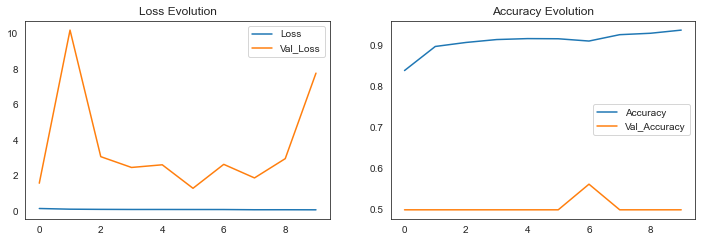

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
evaluation =efficientnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = efficientnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 11s 17ms/step - loss: 5.7631 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%
652/652 [==============================] - 96s 147ms/step - loss: 3.9585 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000
Train Accuracy: 74.29%


# Nasnet

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(331, 331))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(331, 331))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(331, 331))
                                        
sns.set_style('white')
generated_image, label = train.__getitem__(0)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.python.keras.applications.nasnet import NASNetLarge

nasnet_base_model = NASNetLarge(input_shape=(331,331,3), include_top=False, weights='imagenet')

In [ ]:
    nasnet_base_model = tf.keras.Sequential([
        nasnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    nasnet_base_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [ ]:
    r = nasnet_base_model.fit(train,
      epochs=10,
      validation_data=validation,
      class_weight=class_weight,
    steps_per_epoch=len(train),
    validation_steps=len(validation),)

Epoch 1/10
652/652 [==============================] - 479s 691ms/step - loss: 0.2730 - accuracy: 0.6394 - precision: 0.8398 - recall: 0.6359 - val_loss: 5754450.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
652/652 [==============================] - 442s 678ms/step - loss: 0.2645 - accuracy: 0.5775 - precision: 0.7983 - recall: 0.5770 - val_loss: 8628332920832.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
652/652 [==============================] - 437s 670ms/step - loss: 0.2487 - accuracy: 0.5627 - precision: 0.8552 - recall: 0.4952 - val_loss: 21462306816.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
652/652 [==============================] - 475s 729ms/step - loss: 0.2071 - accuracy: 0.6687 - precision: 0.9420 - recall: 0.5905 - val_loss: 2569710.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
652/652 [==============================] - 

Text(0.5, 1.0, 'Accuracy Evolution')

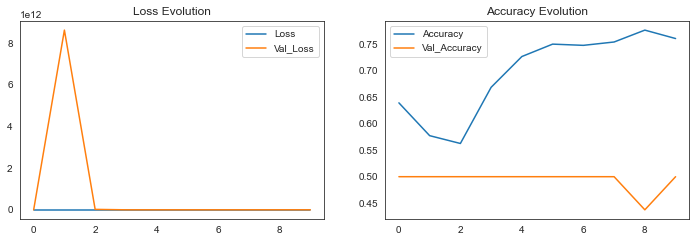

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =efficientnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = efficientnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 16s 26ms/step - loss: 5.5841 - accuracy: 0.6234 - precision: 0.6244 - recall: 0.9974
Test Accuracy: 62.34%
652/652 [==============================] - 119s 182ms/step - loss: 3.7447 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000
Train Accuracy: 74.29%
